In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import pprint
import multiprocessing
from sklearn.impute import SimpleImputer
import mylib as my
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
import shap

In [3]:
X, y = get_subtype_ml_data()

In [4]:
X_filtered = X.dropna(axis=1, how='all')

In [5]:
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("kmeans", KMeans(n_clusters=y.nunique(), random_state=RANDOM_STATE, n_init="auto")),
    ]
)

In [6]:
pipeline.fit(X_filtered)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('kmeans',
                 KMeans(n_clusters=5, n_init='auto', random_state=42))])

In [7]:
# n_jobs = multiprocessing.cpu_count() // 2
n_jobs = 5

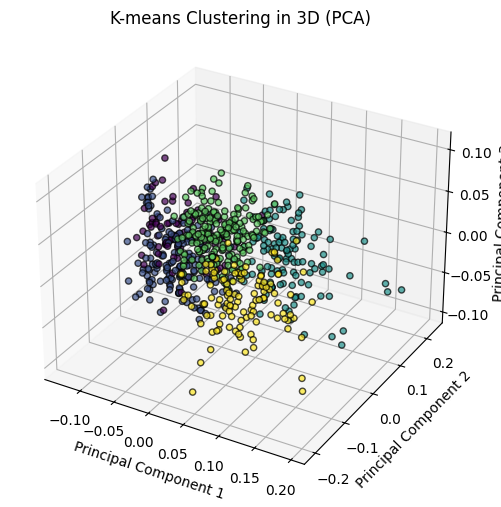

In [8]:
labels = pipeline.named_steps["kmeans"].labels_

pca_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("pca", KernelPCA(n_components=3, kernel="rbf", random_state=RANDOM_STATE, n_jobs=n_jobs)),
    ]
)
X_pca = pca_pipeline.fit_transform(X_filtered)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=labels,
    cmap="viridis",
    marker="o",
    edgecolor="k",
    alpha=0.7,
)
ax.set_title("K-means Clustering in 3D (PCA)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

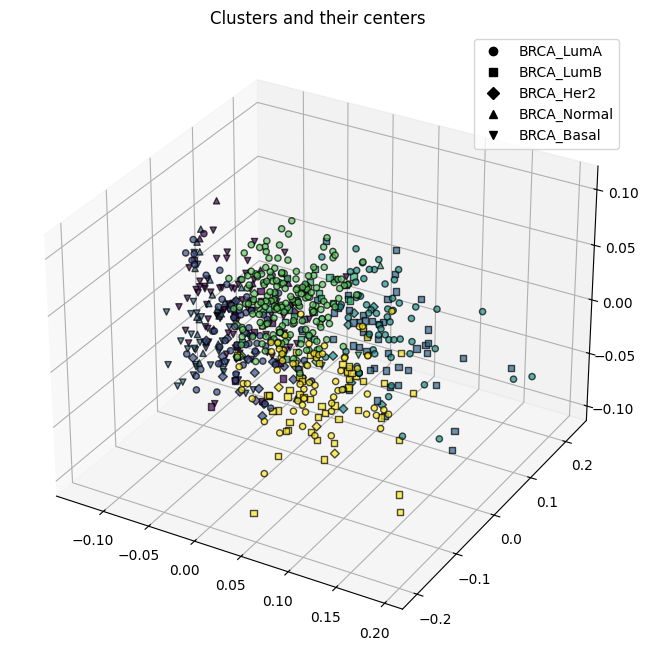

In [9]:
fig = plt.figure(figsize=(32, 8))

# First subplot for the original dataset
# ax1 = fig.add_subplot(131, projection="3d")
# ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c="b", marker=".")
# ax1.set_title("Original dataset")

# Second subplot for the clusters and their centers
ax2 = fig.add_subplot(132, projection="3d")
shapes = {subtype: shape for subtype, shape in zip(y.unique(), ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_'])}
for subtype, shape in shapes.items():
    mask = y == subtype
    ax2.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        X_pca[mask, 2],
        c=labels[mask],
        marker=shape,
        label=subtype,
        edgecolor="k",
        alpha=0.7,
    )
handles, labels = ax2.get_legend_handles_labels()
black_handles = [plt.Line2D([], [], color='k', marker=shape, linestyle='', label=label) for shape, label in zip(shapes.values(), labels)]
ax2.legend(handles=black_handles)
ax2.set_title("Clusters and their centers")

plt.show()

In [10]:
shap.initjs()

In [11]:
feature_names = X_filtered.columns
feature_names

Index(['cg21870274', 'cg08258224', 'cg16619049', 'cg18147296', 'cg13938959',
       'cg12445832', 'cg23999112', 'cg11527153', 'cg27573606', 'cg04195702',
       ...
       'cg26348521', 'cg03370490', 'cg16974513', 'cg23628760', 'cg04920704',
       'cg07236001', 'cg27267896', 'cg23079702', 'cg21073216', 'cg22820726'],
      dtype='object', name='id', length=238569)

In [12]:
def model_fit_transform(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
    return pipeline.transform(data_asframe)

In [13]:
explainer = shap.KernelExplainer(model_fit_transform, shap.sample(X_filtered, 10, random_state=RANDOM_STATE))

In [14]:
explainer(X_filtered.iloc[0])

MemoryError: Unable to allocate 8.31 TiB for an array with shape (478880, 2385690) and data type float64

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    pipeline,
    X_filtered,
    None,
    n_repeats=5,
    random_state=RANDOM_STATE,
    n_jobs=20,
)

# Map importance scores to original feature names
feature_importances = dict(zip(feature_names, result.importances_mean))